# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn.metrics import log_loss
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
from sklearn.calibration import CalibrationDisplay
from itertools import combinations
from itertools import permutations
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
import optuna
from xgboost import XGBClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
import joblib
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
sns.set(style = 'ticks')

In [2]:
train_total = pd.read_csv('/kaggle/input/playground-series-s3e11/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e11/test.csv')
original = pd.read_csv('/kaggle/input/media-campaign-cost-prediction/train_dataset.csv')
x_train, x_test, y_train, y_test = train_test_split(train_total.drop(['cost'], axis = 1), train_total['cost'], test_size = 0.2, stratify = train_total['cost'], random_state = 100)
train = pd.merge(x_train, y_train, on = x_train['id'])
hold = pd.merge(x_test, y_test, on = x_test['id'])
train['id'] = range(0, len(train))
def empty_callback(env):
    pass

# Feature Engineering/Selection

In [3]:
FEATS = ['total_children', 'num_children_at_home', 'avg_cars_at home(approx).1', 'store_sqft', 'coffee_bar', 'video_store', 'florist', 'prepared_food']
INIT_FEATS = ['total_children', 'num_children_at_home', 'avg_cars_at home(approx).1', 'unit_sales(in millions)', 'store_sales(in millions)', 'units_per_case', 'store_sqft', 'coffee_bar', 'video_store', 'florist', 'prepared_food', 'average_children', 'average_units', 'average_sales', 'gross_weight']

CAT_FEATS = FEATS.copy()
avg_df = pd.DataFrame(index = train.store_sqft.unique())
avg_df['store_sqft'] = avg_df.index

avg_df_test = pd.DataFrame(index = test.store_sqft.unique())
avg_df_test['store_sqft'] = avg_df_test.index

avg_df_hold = pd.DataFrame(index = hold.store_sqft.unique())
avg_df_hold['store_sqft'] = avg_df_hold.index

avg_df_original = pd.DataFrame(index = original.store_sqft.unique())
avg_df_original['store_sqft'] = avg_df_original.index

concat_train_hold_test = pd.concat([train, hold, test], ignore_index = True)
for feature in INIT_FEATS:
    if feature in ['units_per_case', 'store_sales(in millions)', 'total_children']:
        avg_df[f'avg_{feature}'] = concat_train_hold_test.groupby('store_sqft')[feature].mean()
        avg_df_test[f'avg_{feature}'] = concat_train_hold_test.groupby('store_sqft')[feature].mean()
        avg_df_hold[f'avg_{feature}'] = concat_train_hold_test.groupby('store_sqft')[feature].mean()
        avg_df_original[f'avg_{feature}'] = concat_train_hold_test.groupby('store_sqft')[feature].mean()
        
        CAT_FEATS.append(f'avg_{feature}')
        
train = pd.merge(train, avg_df, on = 'store_sqft', how = 'left')
hold = pd.merge(hold, avg_df_hold, on = 'store_sqft', how = 'left')
test = pd.merge(test, avg_df_test, on = 'store_sqft', how = 'left')
original = pd.merge(original, avg_df_original, on = 'store_sqft', how = 'left')
avg_df.head()

,store_sqft,avg_total_children,avg_store_sales(in millions),avg_units_per_case
21215.0,21215.0,2.376341,6.429552,18.966716
27694.0,27694.0,2.365320,6.491849,19.027253
30268.0,30268.0,2.648062,6.498345,18.915053
23593.0,23593.0,2.676023,6.478760,18.942552
23598.0,23598.0,2.372495,6.536925,19.009008


In [4]:
FEATS

['total_children',
 'num_children_at_home',
 'avg_cars_at home(approx).1',
 'store_sqft',
 'coffee_bar',
 'video_store',
 'florist',
 'prepared_food']

In [5]:
CAT_FEATS

['total_children',
 'num_children_at_home',
 'avg_cars_at home(approx).1',
 'store_sqft',
 'coffee_bar',
 'video_store',
 'florist',
 'prepared_food',
 'avg_total_children',
 'avg_store_sales(in millions)',
 'avg_units_per_case']

In [6]:
train[FEATS] = train[FEATS].round(2)
original[FEATS] = original[FEATS].round(2)

In [7]:
train.head()

,key_0,id,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,...,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost,avg_total_children,avg_store_sales(in millions),avg_units_per_case
0,141056,0,5.48,4.0,4.0,1.0,2.0,10.1,1.0,0.0,...,21215.0,1.0,0.0,0.0,0.0,0.0,69.63,2.376341,6.429552,18.966716
1,39904,1,6.76,2.0,1.0,0.0,2.0,17.0,0.0,0.0,...,27694.0,1.0,1.0,1.0,1.0,1.0,66.27,2.365320,6.491849,19.027253
2,148590,2,4.40,2.0,5.0,0.0,3.0,17.9,1.0,0.0,...,21215.0,1.0,0.0,0.0,0.0,0.0,138.53,2.376341,6.429552,18.966716
3,10069,3,2.70,3.0,4.0,0.0,1.0,14.0,1.0,1.0,...,30268.0,0.0,0.0,0.0,0.0,0.0,93.07,2.648062,6.498345,18.915053
4,260930,4,8.85,3.0,2.0,2.0,2.0,17.9,1.0,0.0,...,23593.0,0.0,0.0,0.0,0.0,0.0,55.22,2.676023,6.478760,18.942552


In [8]:
num_bins = 5
train['bins'] = pd.cut(train['cost'], bins = num_bins).astype('category')
bins = train['bins'].unique()
bin_map = {}
for i, bin in enumerate(bins):
    bin_map[bin] = i

train['bins'] = train['bins'].map(bin_map)

# Train

In [9]:
ALL_USERS = train.id.unique()
gkf = GroupKFold(n_splits = 5)
oof = pd.DataFrame(index = ALL_USERS)

#hyperparams
cat_params = {
    'iterations': 10000,
    'learning_rate': 0.07,
    'depth': 11,
    'l2_leaf_reg': 8,
    'random_strength': 0.5,
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',
    'task_type': 'GPU',
    'border_count': 128,
    'verbose': 1000, 
    'early_stopping_rounds': 100,
    'use_best_model': True,
    'random_state': 57,
}

xgb_params = {
    'objective': 'reg:squarederror',
    'tree_method': 'gpu_hist',
    'eval_metric': 'rmse',
    'seed': 42,
    'n_estimators': 1000,
    'learning_rate': 0.14774138317002128,
    'early_stopping_rounds': 1000,
    'max_depth': 11,
    'subsample': 0.90,
    'colsample_bytree': 0.90,
    'alpha': 4,
    'lambda': 5
}

targets = np.log(train.cost + 1)
n_splits = 5
kf = KFold(n_splits = 5, shuffle = True, random_state = 100)
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 100)
num_trees_cat = []
num_trees_xgb = []

for i, (train_index, test_index) in enumerate(skf.split(X = train, y = train['bins'], groups = train.index)):
    print(f'\nFold {i + 1}:')
    train_x = train.iloc[train_index]
    train_x = pd.concat([train_x, original])
    train_gems = train_x.index.values
    train_y = targets.loc[train_gems]
    
    valid_x = train.iloc[test_index]
    valid_gems = valid_x.index.values
    valid_y = targets.loc[valid_gems]
    
    model_dict = {
        'cat': [CatBoostRegressor(**cat_params), {'eval_set': [(valid_x[CAT_FEATS].astype('float32'), valid_y)], 'plot': False}, CAT_FEATS],
        'xgb': [XGBRegressor(**xgb_params), {'eval_set': [(valid_x[FEATS].astype('float32'), valid_y)], 'verbose': 0}, FEATS],
    }
    
    all_models = model_dict.keys()
    
    for model in all_models:
        clf = model_dict[model][0]
        clf.fit(train_x[model_dict[model][2]].astype('float32'), train_y, **model_dict[model][1])
        
        oof.loc[valid_gems, f'{model}_prediction'] = np.exp(clf.predict(valid_x[model_dict[model][2]].astype('float32'))) - 1
        print(f'model {model} trained')
        if(model == 'cat'):
            num_trees_cat.append(clf.get_best_iteration())
        if(model == 'xgb'):
            num_trees_xgb.append(clf.best_ntree_limit)


Fold 1:
0:	learn: 0.3154819	test: 0.3144880	best: 0.3144880 (0)	total: 20.8ms	remaining: 3m 28s
bestTest = 0.2933100974
bestIteration = 809
Shrink model to first 810 iterations.
model cat trained
model xgb trained

Fold 2:
0:	learn: 0.3153374	test: 0.3153550	best: 0.3153550 (0)	total: 16.2ms	remaining: 2m 41s
1000:	learn: 0.2994342	test: 0.2930331	best: 0.2930329 (988)	total: 16.6s	remaining: 2m 29s
bestTest = 0.2930297948
bestIteration = 1277
Shrink model to first 1278 iterations.
model cat trained
model xgb trained

Fold 3:
0:	learn: 0.3152626	test: 0.3155185	best: 0.3155185 (0)	total: 16.2ms	remaining: 2m 41s
1000:	learn: 0.2989951	test: 0.2951089	best: 0.2951078 (909)	total: 16.7s	remaining: 2m 30s
bestTest = 0.2951077829
bestIteration = 909
Shrink model to first 910 iterations.
model cat trained
model xgb trained

Fold 4:
0:	learn: 0.3152932	test: 0.3153934	best: 0.3153934 (0)	total: 16.1ms	remaining: 2m 41s
bestTest = 0.2943059523
bestIteration = 586
Shrink model to first 587 it

# Stratified CV

In [10]:
from sklearn.metrics import mean_squared_log_error
rmses = {}
targets = train.cost
for model in all_models:
    rmses[f"{model}_prediction"] = mean_squared_log_error(targets, oof[f'{model}_prediction'], squared = False)
    print(f'{model} = {rmses[f"{model}_prediction"]}')
    
oof['prediction'] = 0
rmse_inv_sum = 0
for model in all_models:
    if model in ['xgb', 'lgb', 'cat']:
        oof['prediction'] = oof['prediction'] + oof[f'{model}_prediction'] * (1 / rmses[f'{model}_prediction'])
        rmse_inv_sum += 1 / rmses[f'{model}_prediction']
        
#print('xgb = 0.2930786590554832')
oof['prediction'] = oof['prediction'] / rmse_inv_sum
print(f'ensemble = {mean_squared_log_error(targets, oof[f"prediction"], squared = False)}')

cat = 0.2939432193327111
xgb = 0.2940405102871711
ensemble = 0.2939309693837006


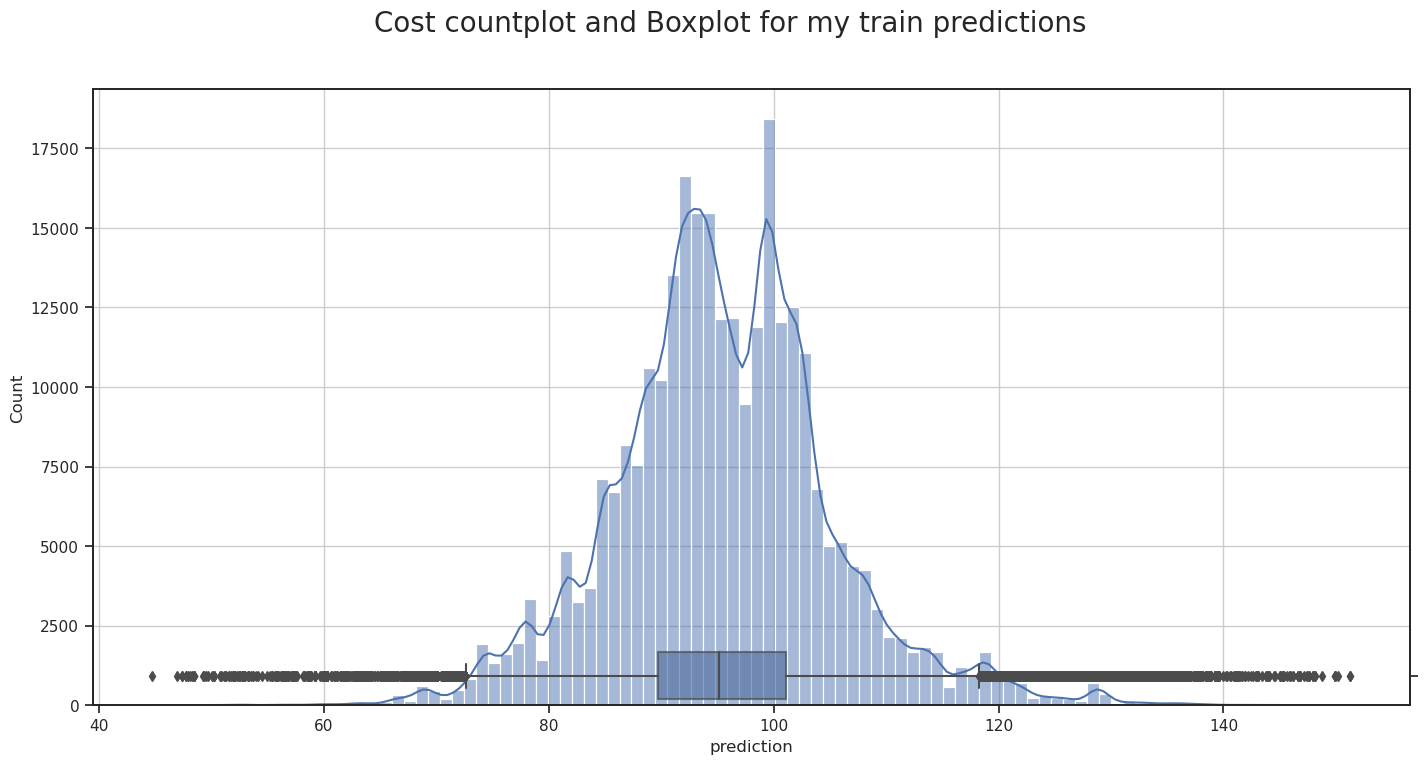

In [11]:
fig, ax = plt.subplots(figsize = (17, 8))
sns.histplot(data = oof, x = 'prediction', bins = 100, ax = ax, kde = True)
ax2 = ax.twinx()
sns.boxplot(data = oof, x = 'prediction', ax = ax2, boxprops = dict(alpha = .7))
ax2.set(ylim = (-.5, 10))
plt.suptitle('Cost countplot and Boxplot for my train predictions', fontsize = 20)
ax.grid(True)
plt.show()

# Hold

In [12]:
print(f'CAT : {num_trees_cat}; mean : {np.array(num_trees_cat).mean()}')
print(f'XGB : {num_trees_xgb}; mean : {np.array(num_trees_xgb).mean()}')
print()
hold_num_trees_cat = int(np.array(num_trees_cat).mean() * 1.25)
hold_num_trees_xgb = int(np.array(num_trees_xgb).mean() * 1.25)

#cat_model
cat_params2 = cat_params.copy()
cat_params2.pop('iterations')
cat_params2.pop('early_stopping_rounds')
cat_params2.pop('use_best_model')
new_params = {
    'iterations': hold_num_trees_cat,
}

hold_cat = CatBoostRegressor(**cat_params2, **new_params)
hold_cat.fit(train[CAT_FEATS].astype('float32'), np.log(train.cost + 1), plot = False)

#xgb_model
xgb_params2 = xgb_params.copy()
xgb_params2.pop('early_stopping_rounds')
xgb_params2['n_estimators'] = hold_num_trees_xgb

hold_xgb = XGBRegressor(**xgb_params2)
hold_xgb.fit(train[FEATS].astype('float32'), np.log(train.cost + 1))

#hold_oof
hold_pred = pd.DataFrame(index = hold.id)

hold_pred['cat_predictions'] = np.exp(hold_cat.predict(hold[CAT_FEATS].astype('float32'))) - 1
hold_pred['xgb_predictions'] = np.exp(hold_xgb.predict(hold[FEATS].astype('float32'))) - 1
hold_pred['predictions'] = (hold_pred['xgb_predictions'] + hold_pred['cat_predictions']) / 2

#rmsles
print(f"\nhold cat prediction: {mean_squared_log_error(hold.cost, hold_pred['cat_predictions'], squared  = False)}")
print(f"\nhold xgb prediction: {mean_squared_log_error(hold.cost, hold_pred['xgb_predictions'], squared  = False)}")
print(f"\nhold ensemble prediction: {mean_squared_log_error(hold.cost, hold_pred['predictions'], squared  = False)}")



CAT : [809, 1277, 909, 586, 948]; mean : 905.8
XGB : [970, 984, 958, 963, 997]; mean : 974.4

0:	learn: 0.3149350	total: 16.5ms	remaining: 18.7s
1000:	learn: 0.2912935	total: 16s	remaining: 2.09s
1131:	learn: 0.2912778	total: 17.9s	remaining: 0us

hold cat prediction: 0.2935548874109697

hold xgb prediction: 0.2935512255175029

hold ensemble prediction: 0.2934843725978681


In [13]:
hold_pred.head()

,cat_predictions,xgb_predictions,predictions
id,,,
191948,112.643188,112.884872,112.764030
143368,91.411422,91.996666,91.704044
16664,99.734901,99.682533,99.708717
49607,99.685030,99.669617,99.677323
228005,108.394904,108.186714,108.290809


# Inference

In [14]:
new_params = {
    'iterations': int(hold_num_trees_cat * 1.25),
}

last_train = pd.concat([train, hold, original], ignore_index = True)

test_cat = CatBoostRegressor(**cat_params2, **new_params)

xgb_params3 = xgb_params2.copy()
xgb_params3['n_estimators'] = int(xgb_params3['n_estimators'] * 1.25)
test_xgb = XGBRegressor(**xgb_params3)

test_xgb.fit(last_train[FEATS].astype('float32'), np.log(last_train.cost + 1))
test_cat.fit(last_train[CAT_FEATS].astype('float32'), np.log(last_train.cost + 1), plot = False)

submission = pd.DataFrame(index = test.id)
submission['id'] = submission.index

submission['cost_xgb'] = np.exp(test_xgb.predict(test[FEATS].astype('float32'))) - 1
submission['cost_cat'] = np.exp(test_cat.predict(test[CAT_FEATS].astype('float32'))) - 1
submission['cost'] = (submission['cost_xgb'] + submission['cost_cat']) / 2

0:	learn: 0.3151419	total: 16.4ms	remaining: 23.1s
1000:	learn: 0.2922708	total: 15.7s	remaining: 6.47s
1414:	learn: 0.2922401	total: 22.3s	remaining: 0us


In [15]:
submission.head()

,id,cost_xgb,cost_cat,cost
id,,,,
360336,360336,90.134430,90.210890,90.172660
360337,360337,94.201973,94.277054,94.239513
360338,360338,94.396187,94.396273,94.396230
360339,360339,99.006927,99.182333,99.094630
360340,360340,78.339905,78.381358,78.360631


In [16]:
sub = submission[['id', 'cost']].to_csv('submission.csv', index = False)